                                        # Machine Learning Final Project 
                                       Models : Random Forest, Ada boost, Gradient boost, XGBoost
                                       Sampling Methods : Random Undersampling 
                                       Creator : Divya

References: 
- https://beckernick.github.io/oversampling-modeling/
- https://towardsdatascience.com/imbalanced-class-sizes-and-classification-models-a-cautionary-tale-part-2-cf371500d1b3
- https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa
- https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
- https://medium.com/turo-engineering/how-not-to-use-random-forest-265a19a68576
- https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm
- https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
- https://www.dataschool.io/comparing-supervised-learning-algorithms/
- https://www.kaggle.com/residentmario/oversampling-with-smote-and-adasyn
- https://stats.stackexchange.com/questions/255765/does-random-forest-need-input-variables-to-be-scaled-or-centered
- https://towardsdatascience.com/fraud-detection-under-extreme-class-imbalance-c241854e60c
- https://www.kaggle.com/karvalo/kaggle-2019-survey-eda (DATA)

In [0]:
#Import Packages 
import pandas as pd
import numpy as np
import matplotlib as mpl
#from plotnine import *

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data-processing modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

# Modeling and evaluation modules 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

# Sampling : 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
    
#warnings 
import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility 
SEED = 42

In [0]:
#Import Dataset - df_new
# 1. Import full data set using Pandas:
#df = pd.read_csv("df_new.csv", low_memory= False)
#df.shape

In [138]:
# Set up shared drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load dataset 
datapath = '/content/drive/Shared drives/Machine Learning/Code/df_new.csv'
df = pd.read_csv(datapath)

In [0]:
#removing first column
df = df.drop(df.columns[0], axis = 1)

In [0]:
# dropping Step. Column Day created from Step will be used instead. 
df = df.drop('step', axis=1) 

In [142]:
df.head(1)

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,day,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
0,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,0,0,0,1,0,0,1,1,0,0,0


In [143]:
#Creating X dataframe (predictors). 
#It should include every feature except for the target variable which is "isFraud".
X = df.drop('isFraud', axis=1) 
X.shape

(6362620, 19)

In [144]:
y = df['isFraud']
y.value_counts() # data is unbalanced
#y.head(1)

0    6354407
1       8213
Name: isFraud, dtype: int64

# Train Test Split 

In [0]:
#Split into train / test set using an 80/20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=SEED) #random state = SEED 

# **Undersampling**


In [0]:
#combine them back for resampling : https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36
train_data = pd.concat([X_train, y_train], axis=1)

In [0]:
# separate minority and majority classes
negative = train_data[train_data.isFraud==0]
positive = train_data[train_data.isFraud==1]

In [0]:
# downsample majority
neg_downsampled = resample(negative,
 replace=True, # sample with replacement
 n_samples=len(positive), # match number in minority class
 random_state=SEED) # reproducible results

In [0]:
downsampled = pd.concat([positive, neg_downsampled])

In [150]:
# check new class counts
downsampled.head(2)

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,day,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4,isFraud
1030389,1735466.52,1735466.52,0.0,0.0,0.0,0.0,1735466.52,2,0,0,0,0,1,1,0,0,0,0,1,1
6168683,316877.85,316877.85,0.0,0.0,0.0,0.0,316877.85,23,0,0,0,0,1,1,0,0,0,0,1,1


In [151]:
downsampled.shape

(13186, 20)

In [152]:
X_train_res = downsampled.drop('isFraud', axis=1) 
X_train_res.head(1)

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,day,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM,quartile1,quartile2,quartile3,quartile4
1030389,1735466.52,1735466.52,0.0,0.0,0.0,0.0,1735466.52,2,0,0,0,0,1,1,0,0,0,0,1


In [153]:
y_train_res = downsampled['isFraud']
count = y_train_res.value_counts() # train data is balanced
count

1    6593
0    6593
Name: isFraud, dtype: int64

In [154]:
X_train_res.shape

(13186, 19)

In [155]:
y_train_res.shape

(13186,)

In [156]:
count_test = y_test.value_counts() # train data is balanced
count_test

0    1270904
1       1620
Name: isFraud, dtype: int64

In [157]:
Percentage_imbalance = (count_test[1]/count_test[0])*100
Percentage_imbalance
# As we can see the train dataset is balanced with respect to fraud and unfraud data points, however, the test validation is performed on a severly unbalanced dataset. 
#Therefore, I think looking into TPR, FNR, FPR are good indicators of model validation. 

0.1274683217615178

# Random Forest with Under-sampling 

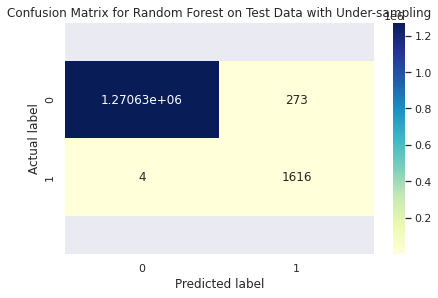

In [158]:
# Create a Random Forest Classifier instance 
rf = RandomForestClassifier(random_state=SEED)
# Fit on X_train and y_train
rf_fit = rf.fit(X_train_res,y_train_res)
# Predict test data 
y_pred_rf_test = rf.predict(X_test)
# Generate confusion matrix and classification report 
cm_rf_test = metrics.confusion_matrix(y_test, y_pred_rf_test)
clr_rf_test = metrics.classification_report(y_test, y_pred_rf_test)
# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_rf_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Random Forest on Test Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [159]:
# extracting TP, TN, FP, and FN values from CM 
TN_rf_test, FP_rf_test, FN_rf_test, TP_rf_test = confusion_matrix(y_test, y_pred_rf_test).ravel()
print(TN_rf_test, FP_rf_test, FN_rf_test, TP_rf_test)  

1270631 273 4 1616


In [0]:
# True positive 
TPR_rf_test = TP_rf_test/(TP_rf_test+FN_rf_test)

In [0]:
#false positive rate 
FPR_rf_test = FP_rf_test/(FP_rf_test+TN_rf_test)

In [0]:
# True Negative
TNR_rf_test = TN_rf_test/(TN_rf_test+FP_rf_test) 

In [0]:
# False Negative 
FNR_rf_test = FN_rf_test/(TP_rf_test+FN_rf_test)

In [164]:
# Print classification report
print(clr_rf_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.86      1.00      0.92      1620

    accuracy                           1.00   1272524
   macro avg       0.93      1.00      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524



In [165]:
# Calculate predicted probabilities 
rf_probs_test = rf.predict_proba(X_test)
# Calculate roc_auc_score for class 1 
rf_roc_auc_test = metrics.roc_auc_score(y_test, rf_probs_test[:,1])
print(rf_roc_auc_test)

0.9994624223640014


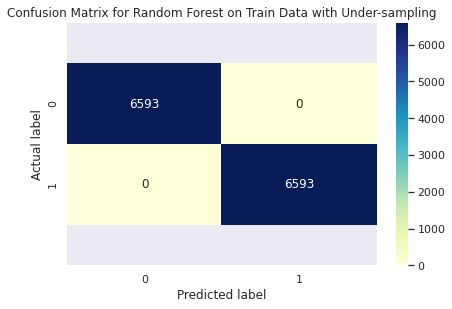

In [166]:
# Predict train data 
y_pred_rf_train = rf.predict(X_train_res)

# Generate confusion matrix and classification report 
cm_rf_train = metrics.confusion_matrix(y_train_res, y_pred_rf_train)
clr_rf_train = metrics.classification_report(y_train_res, y_pred_rf_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_rf_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Random Forest on Train Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [167]:
# extracting TP, TN, FP, and FN values from CM 
TN_rf_train, FP_rf_train, FN_rf_train, TP_rf_train = confusion_matrix(y_train_res, y_pred_rf_train).ravel()
print(TN_rf_train, FP_rf_train, FN_rf_train, TP_rf_train)  

6593 0 0 6593


In [0]:
# True positive 
TPR_rf_train = TP_rf_train/(TP_rf_train+FN_rf_train)


In [0]:
#false positive rate 
FPR_rf_train = FP_rf_train/(FP_rf_train+TN_rf_train)


In [0]:
# True Negative
TNR_rf_train = TN_rf_train/(TN_rf_train+FP_rf_train) 

In [0]:
# False Negative 
FNR_rf_train = FN_rf_train/(TP_rf_train+FN_rf_train)


In [172]:
# Print classification report
print(clr_rf_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      6593

    accuracy                           1.00     13186
   macro avg       1.00      1.00      1.00     13186
weighted avg       1.00      1.00      1.00     13186



In [173]:
# Calculate predicted probabilities 
rf_probs_train = rf.predict_proba(X_train_res)
# Calculate roc_auc_score for class 1 
rf_roc_auc_train = metrics.roc_auc_score(y_train_res, rf_probs_train[:,1])
print(rf_roc_auc_train)

1.0


In [174]:
MSE_rf_test = mean_squared_error(y_test, y_pred_rf_test)
print('Mean squared error - Test: %.4f'
      % MSE_rf_test)

Mean squared error - Test: 0.0002


In [175]:
MSE_rf_train = mean_squared_error(y_train_res, y_pred_rf_train)
print('Mean squared error - Train: %.4f'
      % MSE_rf_train)

Mean squared error - Train: 0.0000


In [0]:
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test, y_pred_rf_test)
fpr_rf_train, tpr_rf_train, thresholds_rf_train = roc_curve(y_train_res, y_pred_rf_train)


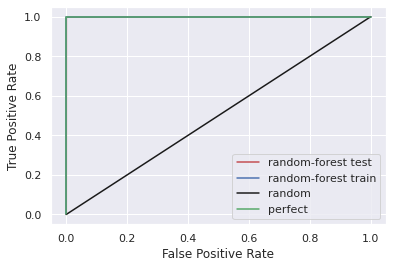

In [177]:
plt.plot(fpr_rf_test, tpr_rf_test,'r-',label = 'random-forest test')
plt.plot(fpr_rf_train,tpr_rf_train,'b-', label= 'random-forest train')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


# AdaBoost Classifier with Under-sampling 

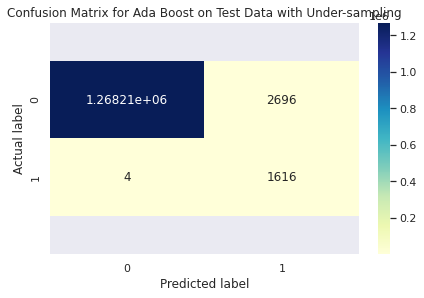

In [178]:
# Create a Adaboost Classifier instance 
ada = AdaBoostClassifier(random_state=SEED)
# Fit on X_train and y_train
ada_fit = ada.fit(X_train_res,y_train_res)
# Predict test data 
y_pred_ada_test = ada.predict(X_test)
# Generate confusion matrix and classification report 
cm_ada_test = metrics.confusion_matrix(y_test, y_pred_ada_test)
clr_ada_test = metrics.classification_report(y_test, y_pred_ada_test)
# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_ada_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Ada Boost on Test Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [179]:
# extracting TP, TN, FP, and FN values from CM 
TN_ada_test, FP_ada_test, FN_ada_test, TP_ada_test = confusion_matrix(y_test, y_pred_ada_test).ravel()
print(TN_ada_test, FP_ada_test, FN_ada_test, TP_ada_test)  

1268208 2696 4 1616


In [0]:
# True positive 
TPR_ada_test = TP_ada_test/(TP_ada_test+FN_ada_test)

In [0]:
#false positive rate 
FPR_ada_test = FP_ada_test/(FP_ada_test+TN_ada_test)

In [0]:
# True Negative
TNR_ada_test = TN_ada_test/(TN_ada_test+FP_ada_test) 

In [0]:
# False Negative 
FNR_ada_test = FN_ada_test/(TP_ada_test+FN_ada_test)

In [184]:
# Print classification report
print(clr_ada_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.37      1.00      0.54      1620

    accuracy                           1.00   1272524
   macro avg       0.69      1.00      0.77   1272524
weighted avg       1.00      1.00      1.00   1272524



In [185]:
# Calculate predicted probabilities 
ada_probs_test = ada.predict_proba(X_test)
# Calculate roc_auc_score for class 1 
ada_roc_auc_test = metrics.roc_auc_score(y_test, ada_probs_test[:,1])
print(ada_roc_auc_test)

0.999832690056414


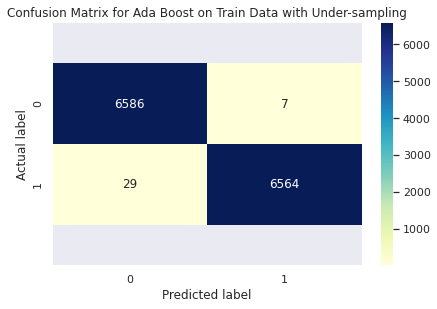

In [186]:
# Predict train data 
y_pred_ada_train = ada.predict(X_train_res)

# Generate confusion matrix and classification report 
cm_ada_train = metrics.confusion_matrix(y_train_res, y_pred_ada_train)
clr_ada_train = metrics.classification_report(y_train_res, y_pred_ada_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_ada_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Ada Boost on Train Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [187]:
# extracting TP, TN, FP, and FN values from CM 
TN_ada_train, FP_ada_train, FN_ada_train, TP_ada_train = confusion_matrix(y_train_res, y_pred_ada_train).ravel()
print(TN_ada_train, FP_ada_train, FN_ada_train, TP_ada_train)  

6586 7 29 6564


In [0]:
# True positive 
TPR_ada_train = TP_ada_train/(TP_ada_train+FN_ada_train)

In [0]:
#false positive rate 
FPR_ada_train = FP_ada_train/(FP_ada_train+TN_ada_train)

In [0]:
# True Negative
TNR_ada_train = TN_ada_train/(TN_ada_train+FP_ada_train) 

In [0]:
# False Negative 
FNR_ada_train = FN_ada_train/(TP_ada_train+FN_ada_train)

In [192]:
# Print classification report
print(clr_ada_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      6593

    accuracy                           1.00     13186
   macro avg       1.00      1.00      1.00     13186
weighted avg       1.00      1.00      1.00     13186



In [193]:
# Calculate predicted probabilities 
ada_probs_train = ada.predict_proba(X_train_res)
# Calculate roc_auc_score for class 1 
ada_roc_auc_train = metrics.roc_auc_score(y_train_res, ada_probs_train[:,1])
print(ada_roc_auc_train)

0.999931190205387


In [194]:
MSE_ada_test = mean_squared_error(y_test, y_pred_rf_test)
print('Mean squared error - Test: %.4f'
      % MSE_ada_test)


Mean squared error - Test: 0.0002


In [195]:
MSE_ada_train = mean_squared_error(y_train_res, y_pred_rf_train)
print('Mean squared error - Train: %.4f'
      % MSE_ada_train)

Mean squared error - Train: 0.0000


In [0]:
fpr_ada_test, tpr_ada_test, thresholds_ada_test = roc_curve(y_test, y_pred_ada_test)
fpr_ada_train, tpr_ada_train, thresholds_ada_train = roc_curve(y_train_res, y_pred_rf_train)


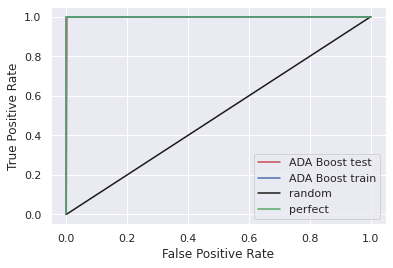

In [197]:
plt.plot(fpr_ada_test, tpr_ada_test,'r-',label = 'ADA Boost test')
plt.plot(fpr_ada_train,tpr_ada_train,'b-', label= 'ADA Boost train')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


# Gradient Boost with Under-sampling 

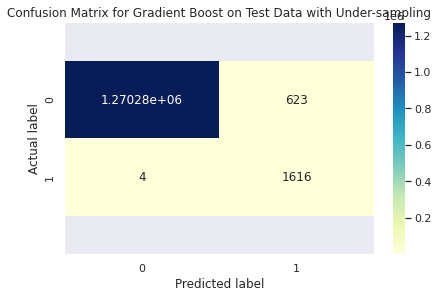

In [198]:
# Create a Gradient Boost instance 
gbc = GradientBoostingClassifier(random_state = SEED)
# Fit on X_train and y_train
gbc_fit = gbc.fit(X_train_res,y_train_res)
# Predict test data 
y_pred_gbc_test = gbc.predict(X_test)
# Generate confusion matrix and classification report 
cm_gbc_test = metrics.confusion_matrix(y_test, y_pred_gbc_test)
clr_gbc_test = metrics.classification_report(y_test, y_pred_gbc_test)
# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_gbc_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Gradient Boost on Test Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [199]:
# extracting TP, TN, FP, and FN values from CM 
TN_gbc_test, FP_gbc_test, FN_gbc_test, TP_gbc_test = confusion_matrix(y_test, y_pred_gbc_test).ravel()
print(TN_gbc_test, FP_gbc_test, FN_gbc_test, TP_gbc_test)  

1270281 623 4 1616


In [0]:
# True positive 
TPR_gbc_test = TP_gbc_test/(TP_gbc_test+FN_gbc_test)

In [0]:
#false positive rate 
FPR_gbc_test = FP_gbc_test/(FP_gbc_test+TN_gbc_test)

In [0]:
# True Negative
TNR_gbc_test = TN_gbc_test/(TN_gbc_test+FP_gbc_test)

In [0]:
# False Negative 
FNR_gbc_test = FN_gbc_test/(TP_gbc_test+FN_gbc_test)

In [204]:
# Print classification report
print(clr_gbc_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.72      1.00      0.84      1620

    accuracy                           1.00   1272524
   macro avg       0.86      1.00      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



In [205]:
# Calculate predicted probabilities 
gbc_probs_test = gbc.predict_proba(X_test)
# Calculate roc_auc_score for class 1 
gbc_roc_auc_test = metrics.roc_auc_score(y_test, gbc_probs_test[:,1])
print(gbc_roc_auc_test)

0.9994835267156583


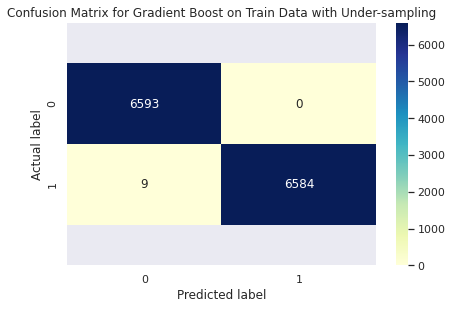

In [206]:
# Predict train data 
y_pred_gbc_train = gbc.predict(X_train_res)

# Generate confusion matrix and classification report 
cm_gbc_train = metrics.confusion_matrix(y_train_res, y_pred_gbc_train)
clr_gbc_train = metrics.classification_report(y_train_res, y_pred_gbc_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_gbc_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Gradient Boost on Train Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [207]:
# extracting TP, TN, FP, and FN values from CM 
TN_gbc_train, FP_gbc_train, FN_gbc_train, TP_gbc_train = confusion_matrix(y_train_res, y_pred_gbc_train).ravel()
print(TN_gbc_train, FP_gbc_train, FN_gbc_train, TP_gbc_train)  

6593 0 9 6584


In [0]:
# True positive 
TPR_gbc_train = TP_gbc_train/(TP_gbc_train+FN_gbc_train)

In [0]:
#false positive rate 
FPR_gbc_train = FP_gbc_train/(FP_gbc_train+TN_gbc_train)

In [0]:
# True Negative
TNR_gbc_train = TN_gbc_train/(TN_gbc_train+FP_gbc_train)

In [0]:
# False Negative 
FNR_gbc_train = FN_gbc_train/(TP_gbc_train+FN_gbc_train)

In [212]:
# Print classification report
print(clr_gbc_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      6593

    accuracy                           1.00     13186
   macro avg       1.00      1.00      1.00     13186
weighted avg       1.00      1.00      1.00     13186



In [213]:
# Calculate predicted probabilities 
gbc_probs_train = gbc.predict_proba(X_train_res)
# Calculate roc_auc_score for class 1 
gbc_roc_auc_train = metrics.roc_auc_score(y_train_res, gbc_probs_train[:,1])
print(gbc_roc_auc_train)

0.9999809168423164


In [214]:
MSE_gbc_test = mean_squared_error(y_test, y_pred_gbc_test)
print('Mean squared error - Test: %.4f'
      % MSE_gbc_test)


Mean squared error - Test: 0.0005


In [215]:
MSE_gbc_train = mean_squared_error(y_train_res, y_pred_gbc_train)
print('Mean squared error - Train: %.4f'
      % MSE_gbc_train)

Mean squared error - Train: 0.0007


In [0]:
fpr_gbc_test, tpr_gbc_test, thresholds_gbc_test = roc_curve(y_test, y_pred_gbc_test)
fpr_gbc_train, tpr_gbc_train, thresholds_gbc_train = roc_curve(y_train_res, y_pred_gbc_train)


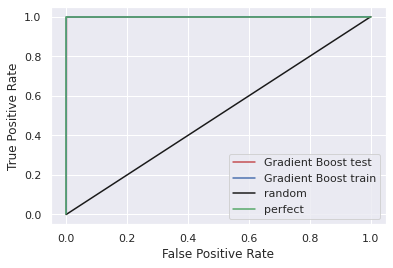

In [217]:
plt.plot(fpr_gbc_test, tpr_gbc_test,'r-',label = 'Gradient Boost test')
plt.plot(fpr_gbc_train,tpr_gbc_train,'b-', label= 'Gradient Boost train')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# XGBoost with Under-sampling 

In [0]:
# Create a XGBoost instance 
xgb = XGBClassifier(random_state = SEED)
# Fit on X_train and y_train
xgb_fit = xgb.fit(X_train_res,y_train_res)
# Predict test data 
y_pred_xgb_test = xgb.predict(X_test)
# Generate confusion matrix and classification report 
cm_xgb_test = metrics.confusion_matrix(y_test, y_pred_xgb_test)
clr_xgb_test = metrics.classification_report(y_test, y_pred_xgb_test)
# Create Heatmap for Confusion Matrix 
#sns.heatmap(cm_xgb_test, annot=True, cmap="YlGnBu" ,fmt='g')
#plt.tight_layout()
#plt.title('Confusion Matrix for XG Boost on Test Data with Under-sampling', y=1.1)
#plt.ylabel('Actual label')
#plt.xlabel('Predicted label')
# Fix for mpl bug that cuts off top/bottom of seaborn visualization
#b, t = plt.ylim() # discover the values for bottom and top
#b += 0.5 # Add 0.5 to the bottom
#t -= 0.5 # Subtract 0.5 from the top
#plt.ylim(b, t) # update the ylim(bottom, top) values
#plt.show()

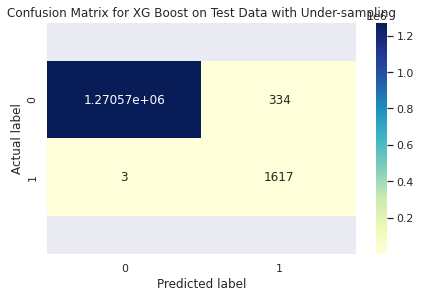

In [219]:
# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_xgb_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for XG Boost on Test Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [220]:
# extracting TP, TN, FP, and FN values from CM 
TN_xgb_test, FP_xgb_test, FN_xgb_test, TP_xgb_test = confusion_matrix(y_test, y_pred_xgb_test).ravel()
print(TN_xgb_test, FP_xgb_test, FN_xgb_test, TP_xgb_test)  

1270570 334 3 1617


In [0]:
# True positive 
TPR_xgb_test = TP_xgb_test/(TP_xgb_test+FN_xgb_test)

In [0]:
#false positive rate 
FPR_xgb_test = FP_xgb_test/(FP_xgb_test+TN_xgb_test)

In [0]:
# True Negative
TNR_xgb_test = TN_xgb_test/(TN_xgb_test+FP_xgb_test)

In [0]:
# False Negative 
FNR_xgb_test = FN_xgb_test/(TP_xgb_test+FN_xgb_test)

In [225]:
# Print classification report
print(clr_xgb_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.83      1.00      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.91      1.00      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



In [226]:
# Calculate predicted probabilities 
xgb_probs_test = xgb.predict_proba(X_test)
# Calculate roc_auc_score for class 1 
xgb_roc_auc_test = metrics.roc_auc_score(y_test, xgb_probs_test[:,1])
print(xgb_roc_auc_test)

0.9996570830635729


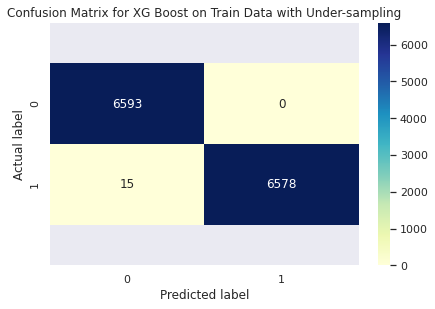

In [227]:
# Predict train data 
y_pred_xgb_train = xgb.predict(X_train_res)

# Generate confusion matrix and classification report 
cm_xgb_train = metrics.confusion_matrix(y_train_res, y_pred_xgb_train)
clr_xgb_train = metrics.classification_report(y_train_res, y_pred_gbc_train)

# Create Heatmap for Confusion Matrix 
sns.heatmap(cm_xgb_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for XG Boost on Train Data with Under-sampling', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [228]:
# extracting TP, TN, FP, and FN values from CM 
TN_xgb_train, FP_xgb_train, FN_xgb_train, TP_xgb_train = confusion_matrix(y_train_res, y_pred_xgb_train).ravel()
print(TN_xgb_train, FP_xgb_train, FN_xgb_train, TP_xgb_train)  

6593 0 15 6578


In [0]:
# True positive 
TPR_xgb_train = TP_xgb_train/(TP_xgb_train+FN_xgb_train)

In [0]:
#false positive rate 
FPR_xgb_train = FP_xgb_train/(FP_xgb_train+TN_xgb_train)

In [0]:
# True Negative
TNR_xgb_train = TN_xgb_train/(TN_xgb_train+FP_xgb_train)

In [0]:
# False Negative 
FNR_xgb_train = FN_xgb_train/(TP_xgb_train+FN_xgb_train)

In [233]:
# Print classification report
print(clr_xgb_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6593
           1       1.00      1.00      1.00      6593

    accuracy                           1.00     13186
   macro avg       1.00      1.00      1.00     13186
weighted avg       1.00      1.00      1.00     13186



In [234]:
# Calculate predicted probabilities 
xgb_probs_train = xgb.predict_proba(X_train_res)
# Calculate roc_auc_score for class 1 
xgb_roc_auc_train = metrics.roc_auc_score(y_train_res, xgb_probs_train[:,1])
print(xgb_roc_auc_train)

0.999966043712187


In [235]:
MSE_xgb_test = mean_squared_error(y_test, y_pred_xgb_test)
print('Mean squared error - Test: %.4f'
      % MSE_xgb_test)

Mean squared error - Test: 0.0003


In [236]:
MSE_xgb_train = mean_squared_error(y_train_res, y_pred_xgb_train)
print('Mean squared error - Train: %.4f'
      % MSE_xgb_train)

Mean squared error - Train: 0.0011


In [0]:
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, y_pred_xgb_test)
fpr_xgb_train, tpr_xgb_train, thresholds_xgb_train = roc_curve(y_train_res, y_pred_xgb_train)

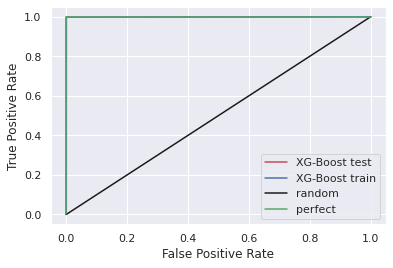

In [238]:
plt.plot(fpr_xgb_test, tpr_xgb_test,'r-',label = 'XG-Boost test')
plt.plot(fpr_xgb_train,tpr_xgb_train,'b-', label= 'XG-Boost train')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Classification Reports - All models 

**Random Forest**

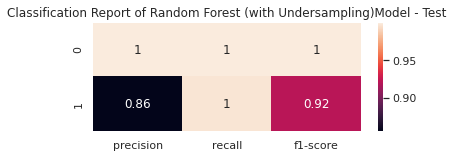

In [239]:
clr_rf_test1 = metrics.classification_report(y_test, y_pred_rf_test, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df1 = pd.DataFrame(clr_rf_test1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df1, annot=True)
plt.title("Classification Report of Random Forest (with Undersampling)Model - Test")
ax.set_ylim(len(df1)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

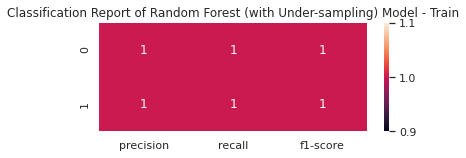

In [240]:
clr_rf_train1 = metrics.classification_report(y_train_res, y_pred_rf_train, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df2 = pd.DataFrame(clr_rf_train1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df2, annot=True)
plt.title("Classification Report of Random Forest (with Under-sampling) Model - Train")
ax.set_ylim(len(df2)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

In [241]:
X.columns

Index(['amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
       'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'day',
       'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER', 'CC', 'CM',
       'quartile1', 'quartile2', 'quartile3', 'quartile4'],
      dtype='object')

In [0]:
columns_ = X.iloc[:,:].columns
n_size=10

In [0]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.
#feat_importances_rf = pd.Series(rf_feature_importance, index=columns_)
#feat_importances_rf.nlargest(10).plot(kind='barh')
#plt.show()

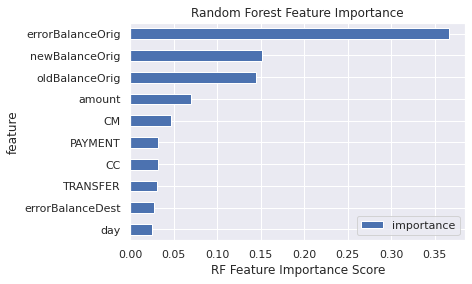

In [244]:
rf_feature_importance = rf.feature_importances_
rf_feat_imp = pd.DataFrame({'importance':rf.feature_importances_})    
rf_feat_imp['feature'] = columns_
rf_feat_imp.sort_values(by='importance', ascending=False, inplace=True)
rf_feat_imp = rf_feat_imp.iloc[:n_size]
rf_feat_imp.sort_values(by='importance', inplace=True)
rf_feat_imp = rf_feat_imp.set_index('feature', drop=True)
rf_feat_imp.plot.barh(title='Random Forest Feature Importance')
plt.xlabel('RF Feature Importance Score')
plt.show()

In [245]:
feat_importances_rf = pd.Series(rf_feature_importance, index=columns_)
feat_importances_rf.nlargest(10)

errorBalanceOrig    0.366843
newBalanceOrig      0.151147
oldBalanceOrig      0.144944
amount              0.070168
CM                  0.046562
PAYMENT             0.032394
CC                  0.031361
TRANSFER            0.031161
errorBalanceDest    0.026730
day                 0.024718
dtype: float64

**Ada Boost**

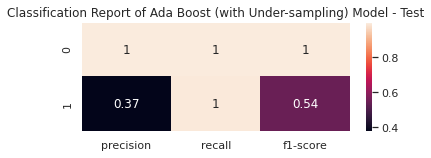

In [246]:
clr_ada_test1 = metrics.classification_report(y_test, y_pred_ada_test, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df3 = pd.DataFrame(clr_ada_test1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df3, annot=True)
plt.title("Classification Report of Ada Boost (with Under-sampling) Model - Test")
ax.set_ylim(len(df3)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

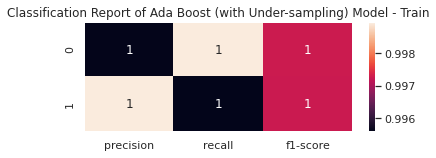

In [247]:
clr_ada_train1 = metrics.classification_report(y_train_res, y_pred_ada_train, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df4 = pd.DataFrame(clr_ada_train1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df4, annot=True)
plt.title("Classification Report of Ada Boost (with Under-sampling) Model - Train")
ax.set_ylim(len(df4)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

In [0]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.
#ada_feature_importance = ada.feature_importances_
#feat_importances_ada = pd.Series(ada_feature_importance, index=columns_)
#feat_importances_ada.nlargest(10).plot(kind='barh')
#plt.show()

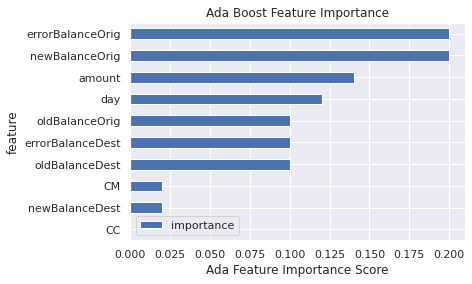

In [249]:
ada_feature_importance = ada.feature_importances_
ada_feat_imp = pd.DataFrame({'importance':ada.feature_importances_})    
ada_feat_imp['feature'] = columns_
ada_feat_imp.sort_values(by='importance', ascending=False, inplace=True)
ada_feat_imp = ada_feat_imp.iloc[:n_size]
ada_feat_imp.sort_values(by='importance', inplace=True)
ada_feat_imp = ada_feat_imp.set_index('feature', drop=True)
ada_feat_imp.plot.barh(title='Ada Boost Feature Importance')
plt.xlabel('Ada Feature Importance Score')
plt.show()

In [250]:
feat_importances_ada = pd.Series(ada_feature_importance, index=columns_)
feat_importances_ada.nlargest(10)

newBalanceOrig      0.20
errorBalanceOrig    0.20
amount              0.14
day                 0.12
oldBalanceOrig      0.10
oldBalanceDest      0.10
errorBalanceDest    0.10
newBalanceDest      0.02
CM                  0.02
CASH_IN             0.00
dtype: float64

**Gradient Boost**

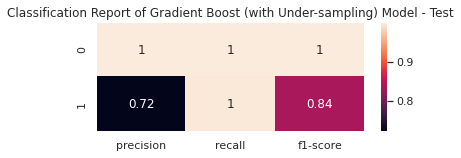

In [251]:
clr_gbc_test1 = metrics.classification_report(y_test, y_pred_gbc_test, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df5 = pd.DataFrame(clr_gbc_test1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df5, annot=True)
plt.title("Classification Report of Gradient Boost (with Under-sampling) Model - Test")
ax.set_ylim(len(df5)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

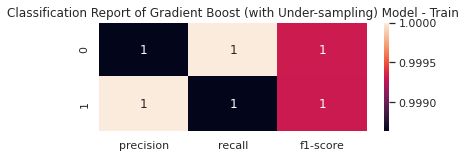

In [252]:
clr_gbc_train1 = metrics.classification_report(y_train_res, y_pred_gbc_train, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df6 = pd.DataFrame(clr_gbc_train1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df6, annot=True)
plt.title("Classification Report of Gradient Boost (with Under-sampling) Model - Train")
ax.set_ylim(len(df6)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

In [0]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.
#gbc_feature_importance = gbc.feature_importances_
#feat_importances_gbc = pd.Series(gbc_feature_importance, index=columns_)
#feat_importances_gbc.nlargest(10).plot(kind='barh')
#plt.show()

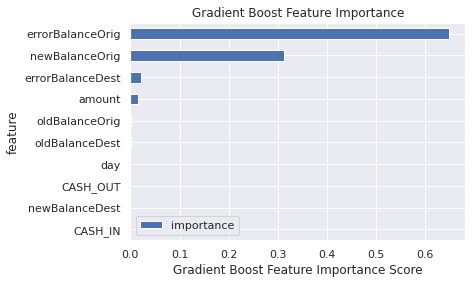

In [254]:
gbc_feature_importance = gbc.feature_importances_
gbc_feat_imp = pd.DataFrame({'importance':gbc.feature_importances_})    
gbc_feat_imp['feature'] = columns_
gbc_feat_imp.sort_values(by='importance', ascending=False, inplace=True)
gbc_feat_imp = gbc_feat_imp.iloc[:n_size]
gbc_feat_imp.sort_values(by='importance', inplace=True)
gbc_feat_imp = gbc_feat_imp.set_index('feature', drop=True)
gbc_feat_imp.plot.barh(title='Gradient Boost Feature Importance')
plt.xlabel('Gradient Boost Feature Importance Score')
plt.show()


In [255]:
feat_importances_gbc = pd.Series(gbc_feature_importance, index=columns_)
feat_importances_gbc.nlargest(10)

errorBalanceOrig    0.648348
newBalanceOrig      0.312605
errorBalanceDest    0.021245
amount              0.015949
oldBalanceOrig      0.000661
oldBalanceDest      0.000524
day                 0.000335
CASH_OUT            0.000107
newBalanceDest      0.000089
CASH_IN             0.000064
dtype: float64

**XG Boost**

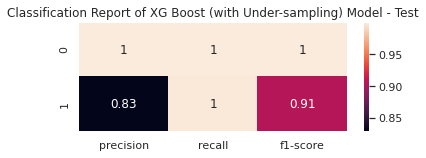

In [256]:
clr_xgb_test1 = metrics.classification_report(y_test, y_pred_xgb_test, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df7 = pd.DataFrame(clr_xgb_test1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df7, annot=True)
plt.title("Classification Report of XG Boost (with Under-sampling) Model - Test")
ax.set_ylim(len(df7)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

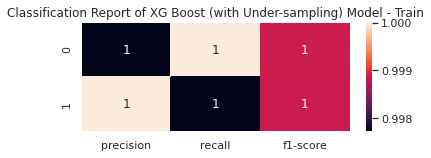

In [257]:
clr_xgb_train1 = metrics.classification_report(y_train_res, y_pred_xgb_train, output_dict=True)
#clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
df8 = pd.DataFrame(clr_xgb_train1).iloc[:-1, :2].T
fig, ax = plt.subplots(figsize = (6, 2))
sns.heatmap(df8, annot=True)
plt.title("Classification Report of XG Boost (with Under-sampling) Model - Train")
ax.set_ylim(len(df8)+0, -0)
fig.savefig("file", bbox_inches = 'tight')
plt.show()

In [0]:
# e) Identify the top 5 features. Feel free to print a list OR to make a plot.
#xgb_feature_importance = xgb.feature_importances_
#feat_importances_xgb = pd.Series(xgb_feature_importance, index=columns_)
#feat_importances_xgb.nlargest(10).plot(kind='barh')
#plt.show()

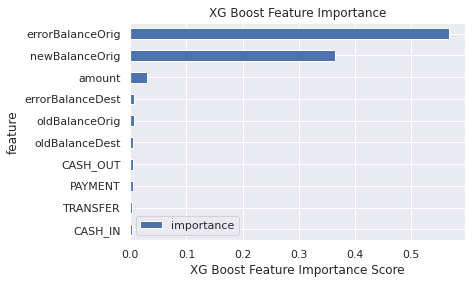

In [259]:
xgb_feature_importance = xgb.feature_importances_
xgb_feat_imp = pd.DataFrame({'importance':xgb.feature_importances_})    
xgb_feat_imp['feature'] = columns_
xgb_feat_imp.sort_values(by='importance', ascending=False, inplace=True)
xgb_feat_imp = xgb_feat_imp.iloc[:n_size]
xgb_feat_imp.sort_values(by='importance', inplace=True)
xgb_feat_imp = xgb_feat_imp.set_index('feature', drop=True)
xgb_feat_imp.plot.barh(title='XG Boost Feature Importance')
plt.xlabel('XG Boost Feature Importance Score')
plt.show()

In [260]:
feat_importances_xgb = pd.Series(xgb_feature_importance, index=columns_)
feat_importances_xgb.nlargest(10)

errorBalanceOrig    0.567739
newBalanceOrig      0.363829
amount              0.029324
errorBalanceDest    0.006424
oldBalanceOrig      0.005757
oldBalanceDest      0.005553
CASH_OUT            0.004345
PAYMENT             0.004124
TRANSFER            0.003558
CASH_IN             0.003459
dtype: float32

# **Model ROC Comparisons**


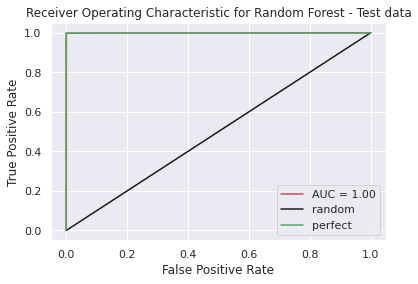

In [261]:
#Random Forest - Test 
plt.title('Receiver Operating Characteristic for Random Forest - Test data')
plt.plot(fpr_rf_test, tpr_rf_test,'r-',label = 'AUC = %0.2f' % rf_roc_auc_test) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


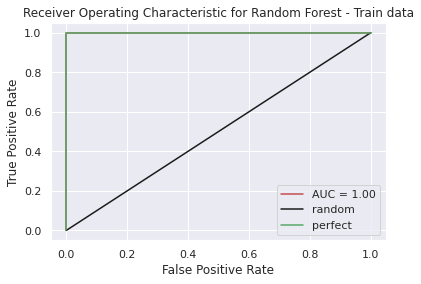

In [262]:
#Random Forest - Train
plt.title('Receiver Operating Characteristic for Random Forest - Train data')
plt.plot(fpr_rf_train, tpr_rf_train,'r-',label = 'AUC = %0.2f' % rf_roc_auc_train) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

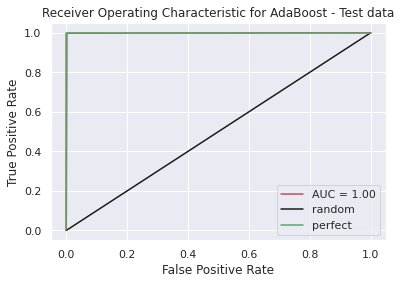

In [263]:
#Ada Boost - Test 
plt.title('Receiver Operating Characteristic for AdaBoost - Test data')
plt.plot(fpr_ada_test, tpr_ada_test,'r-',label = 'AUC = %0.2f' % ada_roc_auc_test) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


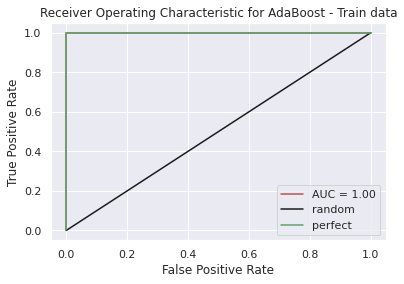

In [264]:
#Ada Boost - Train
plt.title('Receiver Operating Characteristic for AdaBoost - Train data')
plt.plot(fpr_ada_train, tpr_ada_train,'r-',label = 'AUC = %0.2f' % ada_roc_auc_train) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


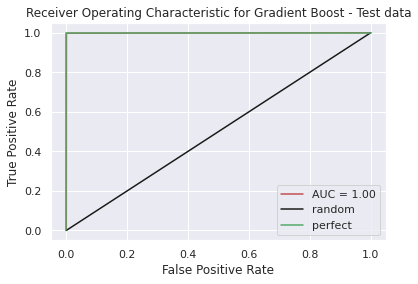

In [265]:
# Gradient Boost - Test 
plt.title('Receiver Operating Characteristic for Gradient Boost - Test data')
plt.plot(fpr_gbc_test, tpr_gbc_test,'r-',label = 'AUC = %0.2f' % gbc_roc_auc_test) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

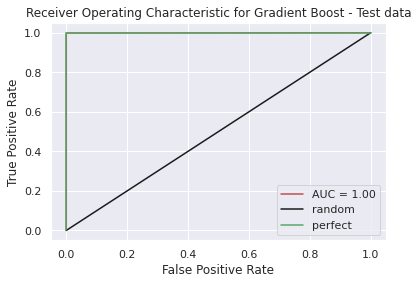

In [266]:
# Gradient Boost - train
plt.title('Receiver Operating Characteristic for Gradient Boost - Test data')
plt.plot(fpr_gbc_train, tpr_gbc_train,'r-',label = 'AUC = %0.2f' % gbc_roc_auc_train) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

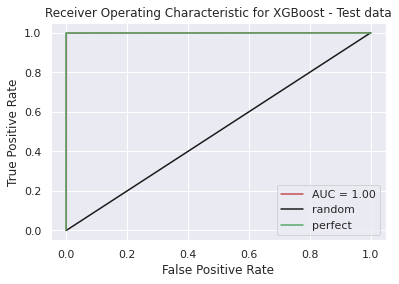

In [267]:
#XGBoost - Test 
plt.title('Receiver Operating Characteristic for XGBoost - Test data')
plt.plot(fpr_xgb_test, tpr_xgb_test,'r-',label = 'AUC = %0.2f' % xgb_roc_auc_test) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


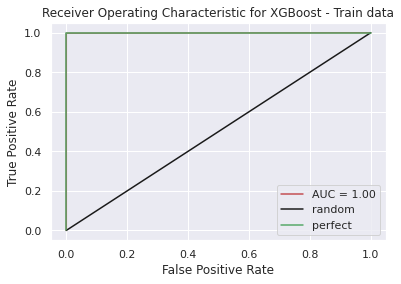

In [268]:
#XGBoost - Train
plt.title('Receiver Operating Characteristic for XGBoost - Train data')
plt.plot(fpr_xgb_train, tpr_xgb_train,'r-',label = 'AUC = %0.2f' % xgb_roc_auc_train) 
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# **Models Summary** 

In [269]:
models_summary_test = [['Random Forest',TPR_rf_test,FPR_rf_test,TNR_rf_test,FNR_rf_test,rf_roc_auc_test,MSE_rf_test],
                  ['AdaBoost',TPR_ada_test,FPR_ada_test,TNR_ada_test,FNR_ada_test,ada_roc_auc_test,MSE_ada_test],
                  ['GradientBoost',TPR_gbc_test,FPR_gbc_test,TNR_gbc_test,FNR_gbc_test,gbc_roc_auc_test,MSE_gbc_test],
                  ['XGBoost ',TPR_xgb_test,FPR_xgb_test,TNR_xgb_test,FNR_xgb_test,xgb_roc_auc_test,MSE_xgb_test]]
models_summary_test_df = pd.DataFrame(models_summary_test,columns=['Test Model','True Positive Rate','False Positive Rate','True Negative Rate','False Negative Rate','AUC score','MSE'])
models_summary_test_df


,Test Model,True Positive Rate,False Positive Rate,True Negative Rate,False Negative Rate,AUC score,MSE
0,Random Forest,0.997531,0.000215,0.999785,0.002469,0.999462,0.000218
1,AdaBoost,0.997531,0.002121,0.997879,0.002469,0.999833,0.000218
2,GradientBoost,0.997531,0.000490,0.999510,0.002469,0.999484,0.000493
3,XGBoost,0.998148,0.000263,0.999737,0.001852,0.999657,0.000265


In [270]:
models_summary_train = [['Random Forest',TPR_rf_train,FPR_rf_train,TNR_rf_train,FNR_rf_train,rf_roc_auc_train,MSE_rf_train],
                  ['AdaBoost',TPR_ada_train,FPR_ada_train,TNR_ada_train,FNR_ada_train,ada_roc_auc_train,MSE_ada_train],
                  ['GradientBoost',TPR_gbc_train,FPR_gbc_train,TNR_gbc_train,FNR_gbc_train,gbc_roc_auc_train,MSE_gbc_train],
                  ['XGBoost ',TPR_xgb_train,FPR_xgb_train,TNR_xgb_train,FNR_xgb_train,xgb_roc_auc_train,MSE_xgb_train]]
models_summary_train_df = pd.DataFrame(models_summary_train,columns=['Train Model','True Positive Rate','False Positive Rate','True Negative Rate','False Negative Rate','AUC score','MSE'])
models_summary_train_df


,Train Model,True Positive Rate,False Positive Rate,True Negative Rate,False Negative Rate,AUC score,MSE
0,Random Forest,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,AdaBoost,0.995601,0.001062,0.998938,0.004399,0.999931,0.000000
2,GradientBoost,0.998635,0.000000,1.000000,0.001365,0.999981,0.000683
3,XGBoost,0.997725,0.000000,1.000000,0.002275,0.999966,0.001138


This is a financial fraud detection casestudy - therefore data is highly imbalanced. Our dataset is extremely high (~6.3 million rows). Therefore, oversampling techniques such as SMOTE and ADASYN took forever to run. Therefore, in this notebook I conducted random under sampling technique  purposes of understanding the outcomes of the models : RF, Ada Boost, Gradient Boost & XGBoost.

By using undersampling technique, we randomly reduced the size of the majority class (not fraud) to be equal to the minority class (fruad). This results in a loss of not fraud data, but helps speed up the algorithm. As we saw the train dataset is balanced with respect to fraud and unfraud data points, however, the test validation is performed on a severly unbalanced dataset. Therefore, I think looking into TPR, FNR, FPR are good indicators of model validation.

Since this is fraud data, I was most interested in the False positive, False negative rates and True positives. The reason is as follows : 

**False Positive : Transactions that were not fraud but were classified as fraud**. From an industry standpoint, if we were to take any action (such as block an account) on transactions detected as fraud, we would like for us to predict this well. No customer is going to be happy if we block their account when they made a legitimate transaction. High false positive rates will result in losing customers, and will be bad for the business. 

**False Negative : Transactions that fraud but were classified as not fraud**. No customer is going to be happy if we dont block their account and safe guard their money when their account was compromised. High false negative rates will result in losing customers due to lack of securityof their hard earned money, and will be bad for the business. 

**True Positive : Transactions that were fraud and classified as Fraud**
TPR of the test data of particular importance to me since we had a balance train data, but severly unbalanced test dataset. So if the model we trained is able to produce a high sensitivity rate to detect fraud during validation, we can say that the model did well. 




Following is my analysis : 
- All test models provided same results for the False negative rate. However, RF had the lowest false positive rate. 
- RF again had the lowest FPR & FNR in the train data. 
- The AUC score between train and test of all models were pretty similar. 
- MSE of Train dataset lower than that of Test for RF & AdaBoost 
- MSE of Train dataset higher than Test for Gradient boost and XGBoost. 

Based on above points, I feel the Random Forest performed the best when using undersampling 